# Target

1. Apply Batch Normalization (BN) to every Convolution Layer and check the results.


# Results

Total Parameters: 9894

Best Training Accuracy: 99.65

Best Test Accuracy: 99.26

# Analysis

1. The model is overfitting.  

2. The training acuracy is 99.65%. So this means that we should not increase the capacity of this model in the immediate subsequent step. The only way to boost the test accuracy is by countering overfitting whilst keeping model capacity in check. 

3. In the next Notebook, we will use Dropout of 5%, 10% and 20% (and select best of these 3 variants) and check model's performance. 

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 12, kernel_size=3, padding=0),
            BatchNorm2d(12),           
            ReLU(inplace=True),

            Conv2d(12, 12, kernel_size=3, padding=0),
            BatchNorm2d(12),             
            ReLU(inplace=True),

            Conv2d(12, 16, kernel_size=3, padding=0),
            BatchNorm2d(16),             
            ReLU(inplace=True),      

            MaxPool2d(kernel_size=2),
            
            Conv2d(16, 12, kernel_size=1, padding=0),
            BatchNorm2d(12),             
            ReLU(inplace=True),

            Conv2d(12, 12, kernel_size=3, padding=0),
            BatchNorm2d(12),             
            ReLU(inplace=True),
            
            Conv2d(12, 12, kernel_size=3, padding=0),
            BatchNorm2d(12),             
            ReLU(inplace=True),

            Conv2d(12, 10, kernel_size=3, padding=0),
            BatchNorm2d(10),             
            ReLU(inplace=True),

            Conv2d(10, 10, kernel_size=5, padding=0),
            BatchNorm2d(10),             
            ReLU(inplace=True),

            Conv2d(10, 10, kernel_size=1)

        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 12, 24, 24]           1,308
       BatchNorm2d-5           [-1, 12, 24, 24]              24
              ReLU-6           [-1, 12, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,744
       BatchNorm2d-8           [-1, 16, 22, 22]              32
              ReLU-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 12, 11, 11]             204
      BatchNorm2d-12           [-1, 12, 11, 11]              24
             ReLU-13           [-1, 12, 11, 11]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.0819641575217247 Batch_id=468 Accuracy=87.54: 100%|██████████| 469/469 [00:10<00:00, 45.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0741, Accuracy: 9837/10000 (98.37%)

EPOCH: 1


Loss=0.03206400200724602 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:09<00:00, 46.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9880/10000 (98.80%)

EPOCH: 2


Loss=0.03588704392313957 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 45.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.1190476045012474 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:10<00:00, 46.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.03594212234020233 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:10<00:00, 46.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.026808984577655792 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:10<00:00, 46.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.008548309095203876 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:09<00:00, 47.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9907/10000 (99.07%)

EPOCH: 7


Loss=0.014349773526191711 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:10<00:00, 46.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.03601973503828049 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:09<00:00, 47.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.009154404513537884 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:10<00:00, 45.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.007179026957601309 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:10<00:00, 46.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.007302582263946533 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:10<00:00, 45.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.011495004408061504 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:10<00:00, 44.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.017219265922904015 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:10<00:00, 44.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9920/10000 (99.20%)

EPOCH: 14


Loss=0.015202537178993225 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:10<00:00, 45.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9895/10000 (98.95%)

EPOCH: 15


Loss=0.022764353081583977 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:10<00:00, 46.08it/s]



Test set: Average loss: 0.0256, Accuracy: 9926/10000 (99.26%)



Text(0.5, 1.0, 'Test Accuracy')

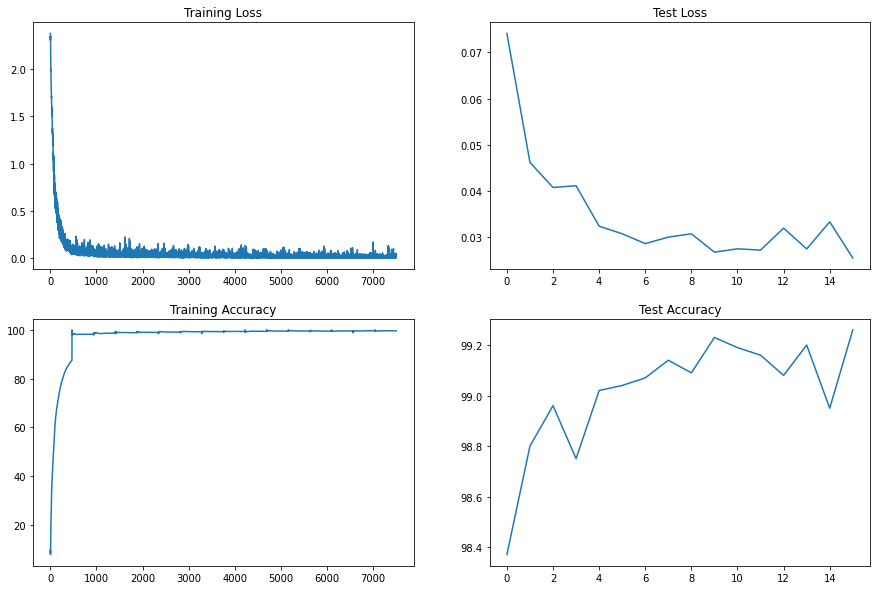

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")